In [212]:
from drivecycle import route, trajectory, utils, plots, graph, energy, simplification

import matplotlib.pyplot as plt

import psycopg

import requests
import polyline
import json
import pandas as pd
import numpy as np

import geopandas as gpd
import math
import json

In [213]:
# Valhalla API
valhalla_host = "http://localhost:8002"

In [214]:
# Connect to gtfs database
conn = psycopg.connect(
        host="localhost",
        dbname="postgis",
        user="username",
        password="password",
    )

###  Get Trip IDs for Route

In [232]:
# BC Transi1t Victoria Route 15
route_id="1"

cur = conn.execute(
    "SELECT DISTINCT ON (trips.shape_id) trips.shape_id,trips.trip_id, trips.direction_id, trips.trip_headsign FROM trips " 
    "JOIN routes ON trips.route_id=routes.route_id "
    "WHERE routes.route_short_name=%s", (route_id,)
    
)
shapes = cur.fetchall()
shapes

[('10135', '64324652', 0, 'CITY CENTRE'),
 ('10149', '64339182', 1, 'CITY CENTRE'),
 ('10155', '64324683', 1, 'CITY CENTRE'),
 ('10157', '64324686', 1, 'BOWNESS'),
 ('10160', '64339098', 1, 'BOWNESS'),
 ('10165', '64326648', 0, 'FOREST LAWN'),
 ('10166', '64324697', 0, 'CITY CENTRE'),
 ('10167', '64332534', 0, 'FOREST LAWN'),
 ('10168', '64339186', 0, 'CITY CENTRE')]

### Get shapes for Trips

In [233]:
# Route 15 Eastbound = index 1
# Route 15 Westbound = index 4
route_index = 3

shape = shapes[route_index][0]

cur = conn.execute(
    "SELECT ST_AsGeoJSON(shapes_aggregated.shape) "
    "FROM shapes_aggregated " 
    "WHERE shapes_aggregated.shape_id=%s ", (shape,)
)

line = cur.fetchall()
geojson = json.loads(line[0][0])
coords = [tuple((i[1],i[0])) for i in geojson["coordinates"]]

### Valhalla Trace Attributes

In [236]:
b = polyline.encode(coords, 6)

trace_route = json.dumps({
    "encoded_polyline":b,
    "costing":"bus"
})

data =json.dumps({
    "encoded_polyline":b,
    "costing":"bus",
    "filters":{
        "attributes":[
            "shape",
            "edge.length",
            "edge.speed",
            "node.intersecting_edge.road_class",
            ],
        "action":"include"
    }
})

height_data = json.dumps({"encoded_polyline":b,"range":True})

# Get Traces (intersections) and elevation from Valhalla
trace = requests.post(f"{valhalla_host}/trace_attributes", data=data)
height = requests.post(f"{valhalla_host}/height", data=height_data)

polyline.decode(trace.json()["shape"])
# import json
# with open(f'calgary-{route_id}-elv.json', 'w') as f:
#     json.dump(height.json()["range_height"], f)

[(510.52006, -1139.41278),
 (510.52022, -1139.41304),
 (510.52061, -1139.41463),
 (510.52071, -1139.4167),
 (510.52072, -1139.41834),
 (510.51696, -1139.41835),
 (510.50537, -1139.41848),
 (510.49224, -1139.4183),
 (510.48526, -1139.41842),
 (510.4696, -1139.41843),
 (510.46885, -1139.41854),
 (510.46756, -1139.41875),
 (510.46597, -1139.4192),
 (510.46366, -1139.42056),
 (510.46231, -1139.42163),
 (510.46062, -1139.42342),
 (510.45852, -1139.42622),
 (510.45814, -1139.42705),
 (510.45643, -1139.43077),
 (510.45453, -1139.43589),
 (510.45303, -1139.44177),
 (510.45289, -1139.44283),
 (510.45241, -1139.44644),
 (510.45191, -1139.45236),
 (510.45178, -1139.45939),
 (510.45181, -1139.46848),
 (510.45181, -1139.46937),
 (510.45181, -1139.47002),
 (510.45189, -1139.49686),
 (510.45195, -1139.5096),
 (510.45077, -1139.50966),
 (510.44726, -1139.50968),
 (510.43605, -1139.50969),
 (510.43188, -1139.50975),
 (510.4197, -1139.50969),
 (510.41686, -1139.50977),
 (510.4149, -1139.51054),
 (510.41

### Get route stop locations & distances

In [222]:
trip_id = shapes[route_index][1]
cur = conn.execute(
    """
    SELECT ARRAY_AGG(b.shape_dist_traveled*1000)
    FROM (SELECT stop_times.stop_id, stop_times.stop_sequence, stop_times.shape_dist_traveled FROM stop_times
    WHERE stop_times.trip_id=%s
    ORDER BY stop_times.stop_sequence) as b
    JOIN stops ON b.stop_id=stops.stop_id
    """,
    (trip_id,))

stops = cur.fetchall()[0][0]



In [175]:
def create_df(trace):
    df = gpd.GeoDataFrame(trace.json()["edges"])
    df["end"] = df["end_node"].map(lambda x: x["intersecting_edges"][0]["road_class"] if "intersecting_edges" in x else None) 
    df["lr"]=df["length"].cumsum()*1000
    df["speed"]=df.apply(lambda x: x["speed"]*(1000/3600), axis=1)
    return df[["speed","end","lr"]]
df = create_df(trace)
df.head()

,speed,end,lr
0,5.555556,service_other,163.0
1,5.555556,service_other,208.0
2,5.555556,tertiary,217.0
3,13.888889,service_other,228.0
4,13.888889,service_other,302.0


In [176]:
def include_stops(df, stops):
    df1 = pd.DataFrame({
        "speed": np.NaN,
        "end": "bus_stop",
        "lr": stops
    })
    return pd.concat([df,df1],axis=0).reset_index()[["speed","end","lr"]].sort_values("lr").ffill().fillna(0)
df1 = include_stops(df, stops)
df1 = df1.round(2)
df1.head(3)

,speed,end,lr
170,0.00,bus_stop,0.0
0,5.56,service_other,163.0
1,5.56,service_other,208.0


In [211]:
df_clustered = simplification.cluster_nodes(df1,30)
df_clustered= df_clustered.round(2)
df_clustered = df_clustered[df_clustered["lr"]>0]
df_clustered.to_json("calgary-21.json",orient="records",indent=2)

In [210]:

df_clustered.head(5)

,speed,end,lr
1,7.64,"[service_other, service_other, tertiary, servi...",195.92
2,13.89,"[service_other, service_other]",308.50
3,13.89,[service_other],380.00
4,13.89,"[service_other, bus_stop, tertiary]",614.98
5,13.89,"[service_other, tertiary, service_other, bus_s...",834.60


In [188]:
stop_params={"bus_stop":60,"tertiary":120, "secondary":60}
tvq = route.sequential(df_clustered, stop_params, step=2, a_max=2)
tvq.shape

-0.0 Error 1: Trajectory is not possible given inputs.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

### Get Drive Cycle

In [80]:
# Stop time durations
stop_params={"bus_stop":60,"tertiary":120, "secondary":60}

# Run for 5 iterations
iterations = 5
arr = np.zeros(iterations)

for i in range(iterations):
    dc = route.sequential(df_clustered, stop_params, step=1, a_max=2)
    elv = height.json()["range_height"]
    soc = energy.energy_model(dc, elv, m=14465, area=8.9, capacity=555)
    
    total_power = soc[-1,3]
    total_dist = soc[-1,2]
    
    # print(total_power, total_dist)
    
    arr[i]=(total_power/(total_dist/1000))
arr.mean()

1.1717742105293347

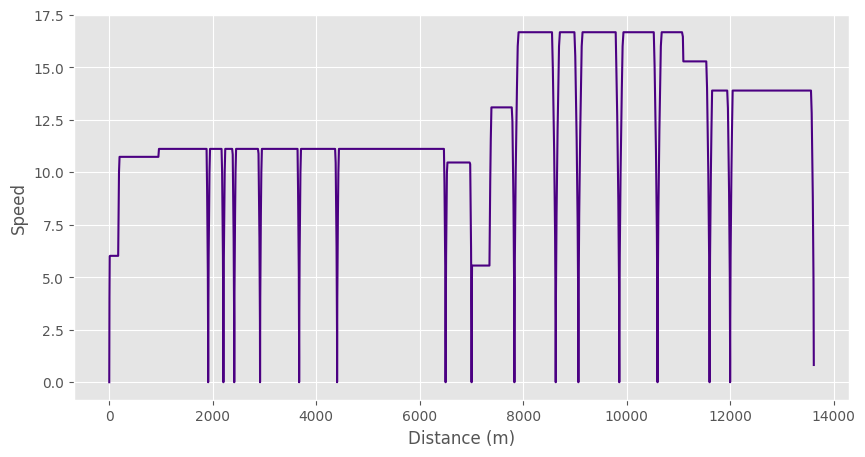

In [81]:
t=[i[2] for i in soc]
p=[i[1] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Speed")
plt.show()

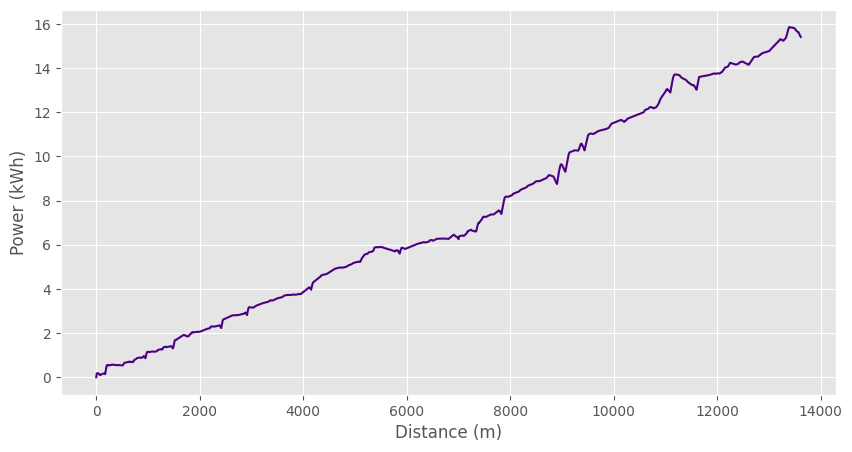

In [74]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

## Validation with test data

In [287]:
time = pd.read_csv("./test_data/Route15/time.csv", header=0)
distance = pd.read_csv("./test_data/Route15/distance.csv", header=0)
speed = pd.read_csv("./test_data/Route15/speed.csv", header=0)

In [288]:
df = pd.concat((time, speed, distance), axis=1)
test_data = df[(distance.ne(distance.shift())).any(axis=1)] #remove duplicate consecutive distances
test_data = test_data.to_numpy()

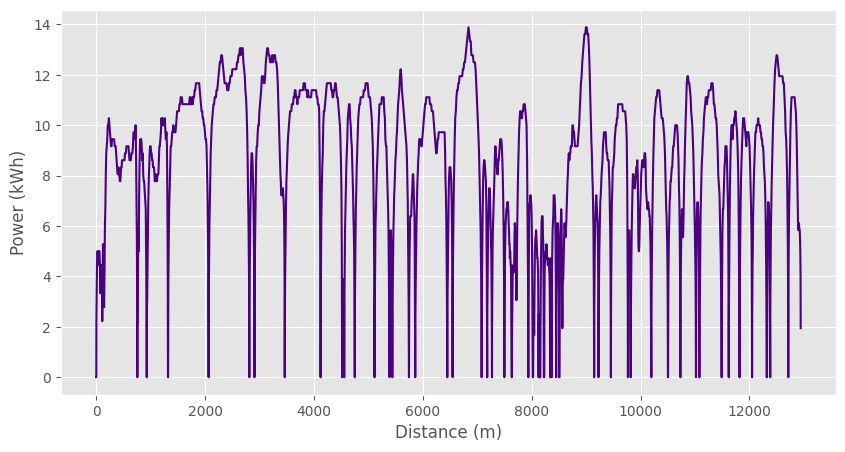

In [289]:
t=[i[2] for i in test_data]
p=[i[1] for i in test_data]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [271]:
soc = energy.energy_model(test_data, elv, m=14465, area=8.9, capacity=555)

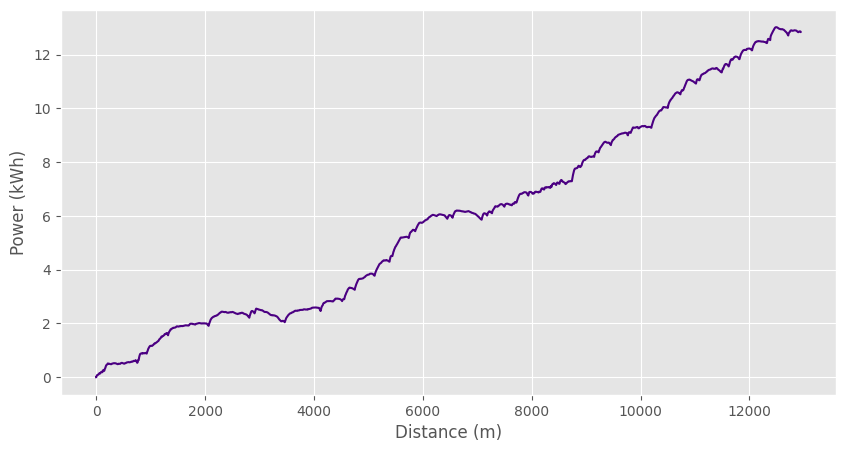

In [272]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [273]:
total_power = soc[-1,3]
total_dist = soc[-1,2]

print(total_power, total_dist)

(total_power/(total_dist/1000))

12.845625780522932 12940.964333


0.9926328092695572

## Summary

|Energy Consumption (kWh/km)       | Eastbound          | Westbound   |
| ------------- |:-------------:| ------:|
| Franca, A. (2015).      |  1.1  | 0.9 |
| Drivecycle Simulation     | 1.26      |   1.08 |
| Drivecycle using test data from Franca, A. (2015).  | -      |    0.99 |